In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import random
#zaczytanie danych
train = pd.read_csv(r"C:\Users\AntoSzu\Downloads\data_green\train_green.csv")
test = pd.read_csv(r"C:\Users\AntoSzu\Downloads\data_green\test_green.csv")

In [2]:
#w zadaniu 3 X to zmienne predykcyjne z modelu
X_train = train.drop(['PRED_BINNED', 'SEG_1', 'SEG_2', 'SEG_3'], axis = 1)
pred_train = train['PRED']
y_train = train['TARGET']
X_test = test.drop(['PRED_BINNED', 'SEG_1', 'SEG_2', 'SEG_3'], axis = 1)
pred_test = test['PRED']
y_test= test['TARGET']
#iloraz szans
train_odds = (pred_train)/(1-pred_train)

In [3]:
#ignorowanie warningów dla notebooka (df_approx['score_diff'] = np.abs(df_approx['PRED']-X_train[i]) produkuje warning)
import warnings
warnings.filterwarnings('ignore')

## MAHALANOBIS DISTANCE

In [4]:
#źródło: https://www.geeksforgeeks.org/how-to-calculate-mahalanobis-distance-in-python/
def calculateMahalanobis(y=None, data=None, cov=None): 
  
    y_mu = y - np.mean(data) 
    if not cov: 
        cov = np.cov(data.values.T) 
    inv_covmat = np.linalg.inv(cov) 
    left = np.dot(y_mu, inv_covmat) 
    mahal = np.dot(left, y_mu.T) 
    return mahal
# .diagonal() 

In [5]:
#dla uproszeczenia do odległości mahalanobisa pozbędziemy się obserwacji z brakami danych
df_mahal_train = X_train.dropna()
pred_mahal_train = df_mahal_train['PRED']
train_odds_mahal = (pred_mahal_train)/(1-pred_mahal_train)
df_mahal_test = X_test.dropna()
pred_mahal_test = df_mahal_test['PRED']

In [6]:
%%time
#przybliżamy prawdopodobieństwo wystąpienia klasy 1 (to będzie nasz y)
#liczba obserwacji służąca do przybliżenia
m = 1000
#liczba obserwacji bez NA (dla uproszczenia żeby odległość mahalanobisa była wyliczalna)
n = len(df_mahal_train)
#conformity scores dla ilorazu szans
conformity_scores = []
#odległość mahalanobisa
mahalanobis_distances = []
#indeksy obserwacji, które nie zawierają NA na żadnej zmiennej
indices = df_mahal_train.index
for i in range(n):
    df_approx = df_mahal_train[['PRED', 'TARGET']]
    df_approx['score_diff'] = np.abs(df_approx['PRED']-df_approx['PRED'][indices[i]])
    a = df_approx.nsmallest(m, 'score_diff')
    indices_temp = np.array(a.index)
    mean_target = np.mean(a['TARGET'])
    mean_odds = mean_target/(1-mean_target)
    conformity_scores.append(np.abs(train_odds_mahal[indices[i]]-mean_odds))
    
    #tworzymy pomocniczą ramkę danych zawierającą 1000 obserwacji o scorze najbliższym rozpatrywanej obserwacji
    a = df_mahal_train.drop(['PRED', 'TARGET'], axis = 1)
    a = a.loc[indices_temp,:]
    #na zerowym miejscu zawsze będzie rozpatrywana aktualnie obserwacja
    #wyznaczamy odległość mahalanobisa od średniej zmiennych predykcyjnych rozkładu wokół danego score'a
    mahalanobis_distances.append(calculateMahalanobis(y = a.iloc[0], data = a))

CPU times: total: 22min 21s
Wall time: 4min 32s


In [7]:
%%time
#analogiczna pętla służąca do wyznaczenia odległości mahalanobisa obserwacji testowej od średniej zmiennych predykcyjnych
#dla 1000 najbliższych scorów

#liczba obserwacji służąca do przybliżenia
m = 1000
#liczba obserwacji testowych, które nie zawierają NA
n_test = len(df_mahal_test)
#indeksy obserwacji, które nie zawierają NA na żadnej zmiennej
indices_2 = df_mahal_test.index
mahalanobis_test = []
#ramka danych ze zmiennymi predykcyjnymi dla obserwacji ze zbioru testowego
b = df_mahal_test.drop(['PRED', 'TARGET'], axis = 1)
for i in range(n_test):
    #grupowanie po scorach najbliższych dla danej obserwacji
    df_approx = df_mahal_train[['PRED', 'TARGET']]
    df_approx['score_diff'] = np.abs(df_approx['PRED']-df_mahal_test['PRED'][indices_2[i]])
    a = df_approx.nsmallest(m, 'score_diff')
    indices_temp = np.array(a.index)
    #odległość mahalanobisa obserwacji od 1000 najbliższych obserwacji ze zbioru kalibracyjnego
    a = df_mahal_train.drop(['PRED', 'TARGET'], axis = 1)
    a = a.loc[indices_temp,:]
    mahalanobis_test.append(calculateMahalanobis(y = b.iloc[i], data = a))

CPU times: total: 1min 28s
Wall time: 19.1 s


In [8]:
%%time
#wyznaczamy unormowaną rangę odległości mahalanobisa dla obserwacji ze zbioru testowego względem "typowych" odległości
#dla zbioru kalibracyjnego
mahalanobis_rank = []
for i in range(n_test):
    mahalanobis_temp = mahalanobis_distances.copy()
    mahalanobis_temp.append(mahalanobis_test[i])
    mahalanobis_rank.append(scipy.stats.rankdata(mahalanobis_temp)[n]/n)

CPU times: total: 14.7 s
Wall time: 14.7 s


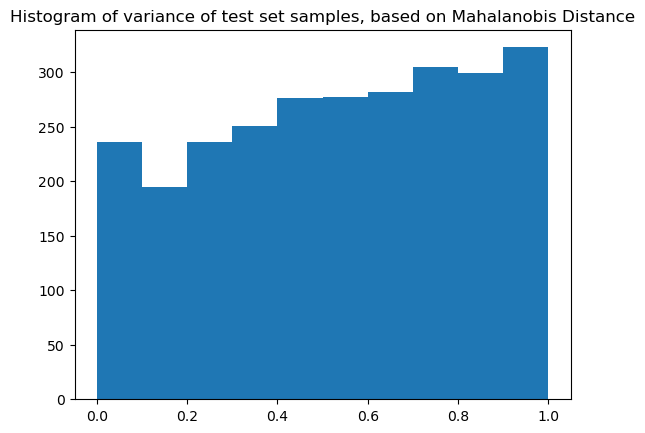

In [10]:
#histogram zmienności dla zbioru testowego
plt.hist(mahalanobis_rank)
plt.title('Histogram of variance of test set samples, based on Mahalanobis Distance')
plt.show()

In [13]:
#conformity scores dla zbioru kalibracyjnego
#conformity_scores = np.maximum(X_train-y_train, y_train-X_train)
#zadany poziom alpha
alpha = 0.01
#liczność próby
#n = len(X_train)
#kwantyl scorów
qhat = np.quantile(conformity_scores, np.ceil((n+1)*(1-alpha))/n)
#regresja dla zbioru testowego
test_odds = (pred_test[indices_2])/(1-pred_test[indices_2])
#przedział dla każdego punktu testowego
output_mahalanobis_lower = []
output_mahalanobis_upper = []
for i in range(n_test):
    output_mahalanobis_lower.append(test_odds[indices_2[i]]-qhat*mahalanobis_rank[i])
    output_mahalanobis_upper.append(test_odds[indices_2[i]]+qhat*mahalanobis_rank[i])

In [24]:
#ile wartości jest unikatowych dla danej zmiennych (aby łatwiej wybrać zmienne do )
for i in df_mahal_test.columns:
    print(f'Zmienna {i}, frakcja unikatowych wartości {len(df_mahal_test[i].unique())/n_test}')

Zmienna PRED, frakcja unikatowych wartości 1.0
Zmienna TARGET, frakcja unikatowych wartości 0.0007462686567164179
Zmienna FEAT_1, frakcja unikatowych wartości 0.004850746268656716
Zmienna FEAT_2, frakcja unikatowych wartości 0.5880597014925373
Zmienna FEAT_3, frakcja unikatowych wartości 0.09664179104477612
Zmienna FEAT_4, frakcja unikatowych wartości 0.07723880597014926
Zmienna FEAT_5, frakcja unikatowych wartości 0.008955223880597015
Zmienna FEAT_6, frakcja unikatowych wartości 0.09029850746268657
Zmienna FEAT_7, frakcja unikatowych wartości 0.013059701492537313
Zmienna FEAT_8, frakcja unikatowych wartości 0.024253731343283583
Zmienna FEAT_9, frakcja unikatowych wartości 0.11007462686567164
Zmienna FEAT_10, frakcja unikatowych wartości 0.33992537313432836
Zmienna FEAT_11, frakcja unikatowych wartości 0.10186567164179104


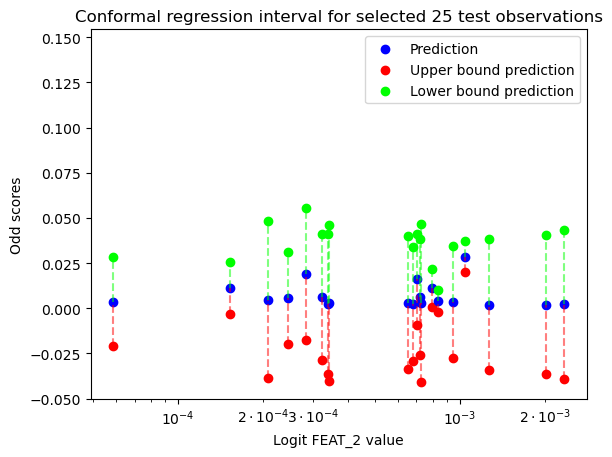

In [26]:
k = 25
variable = 'FEAT_2'
for i in range(k):
    #losujemy indeks obserwacji
    obs_num = random.randint(0,n_test-1)
    #rysujemy predykcję
    plt.scatter(df_mahal_test[variable][indices_2[obs_num]],test_odds[indices_2[obs_num]], color = 'blue')
    #rysujemy górny/dolny kraniec przedziału ufności
    plt.scatter(df_mahal_test[variable][indices_2[obs_num]],output_mahalanobis_lower[obs_num], color = 'r')
    plt.scatter(df_mahal_test[variable][indices_2[obs_num]],output_mahalanobis_upper[obs_num],  color = 'lime')
    #łączymy kreską
    plt.plot((df_mahal_test[variable][indices_2[obs_num]], df_mahal_test[variable][indices_2[obs_num]]), (output_mahalanobis_lower[obs_num], test_odds[indices_2[obs_num]]), color = 'r', linestyle = '--', alpha = 0.5)
    plt.plot((df_mahal_test[variable][indices_2[obs_num]], df_mahal_test[variable][indices_2[obs_num]]), (test_odds[indices_2[obs_num]], output_mahalanobis_upper[obs_num]), color = 'lime', linestyle = '--', alpha = 0.5)

#powtarzamy krok z pętli po raz ostatni, aby dodać label do punktów
obs_num = random.randint(0,n_test-1)
plt.scatter(df_mahal_test[variable][indices_2[obs_num]],test_odds[indices_2[obs_num]], color = 'blue',label = 'Prediction')
plt.scatter(df_mahal_test[variable][indices_2[obs_num]],output_mahalanobis_lower[obs_num], label = 'Upper bound prediction', color = 'r')
plt.scatter(df_mahal_test[variable][indices_2[obs_num]],output_mahalanobis_upper[obs_num], label = 'Lower bound prediction', color = 'lime')
plt.plot((df_mahal_test[variable][indices_2[obs_num]], df_mahal_test[variable][indices_2[obs_num]]), (output_mahalanobis_lower[obs_num], test_odds[indices_2[obs_num]]), color = 'r', linestyle = '--', alpha = 0.5)
plt.plot((df_mahal_test[variable][indices_2[obs_num]], df_mahal_test[variable][indices_2[obs_num]]), (test_odds[indices_2[obs_num]], output_mahalanobis_upper[obs_num]), color = 'lime', linestyle = '--', alpha = 0.5)

plt.legend()
plt.xlabel(f'Logit {variable} value')
plt.ylabel('Odd scores')
plt.xscale('logit')
plt.title(f'Conformal regression interval for selected {k} test observations')
plt.show()